In [1]:
# --- CELL 1: SETUP ---
# 1. Install Reinforcement Learning dependencies
!pip install gymnasium stable-baselines3 shimmy pygame

# 2. Unzip the environment file (Assumes you uploaded 'wildfire-env.zip')
# The -o flag overwrites files without asking (good for re-running)
!unzip -o wildfire-env.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.3 MB/s eta 0:00:00
Archive:  wildfire-env.zip
   creating: wildfire-env/
  inflating: wildfire-env/evaluate_v0.ipynb  
  inflating: wildfire-env/train_v0.ipynb  
  inflating: wildfire-env/.DS_Store  
  inflating: __MACOSX/wildfire-env/._.DS_Store  
  inflating: wildfire-env/LICENSE    
  inflating: wildfire-env/ppo_fire_squad_coop_v0.zip  
  inflating: wildfire-env/train_greedy_v0.ipynb  
   creating: wildfire-env/dist/
  inflating: wildfire-env/train_greedy.ipynb  
  inflating: wildfire-env/pyproject.toml  
  inflating: wildfire-env/evaluate.ipynb  
   creating: wildfire-env/docs/
  inflating: wildfire-env/README.md  
  inflating: wildfire-env/firecast.ipynb  
  inflating: wildfire-env/.gitignore  
   creating: wildfire-env/firecastrl_env/
   creating: wildfire-env/.ipynb_checkpoints/
  inflating: wildfire-env/train.ipynb  
   creating: wildfire-env/.git/
  inflating: wildfire-env/dist/firecastrl_env-0.1.2-py3-none-any.whl  

In [2]:
# --- CELL 2: MOUNT DRIVE & FIX PATHS ---
import sys
import os
import shutil
from google.colab import drive

# 1. Mount Google Drive (So models save while you sleep)
drive.mount('/content/drive')
drive_save_path = "/content/drive/MyDrive/FirecastRL_Models"
os.makedirs(drive_save_path, exist_ok=True)
print(f"✅ Google Drive Mounted. Models will save to: {drive_save_path}")

# 2. Fix the Folder Name Issue
# Python packages cannot have hyphens (-), only underscores (_)
# We check if 'wildfire-env' exists and rename/restructure it so imports work
if os.path.exists("wildfire-env"):
    # Check if this is the package itself or a parent folder
    if os.path.exists("wildfire-env/firecastrl_env"):
        # It's a parent folder, add it to path
        sys.path.append(os.path.abspath("wildfire-env"))
        print("✅ Added 'wildfire-env' folder to Python path.")
    else:
        # It might be the package named wrongly. Let's rename it.
        if os.path.exists("firecastrl_env"):
            shutil.rmtree("firecastrl_env") # Remove existing to avoid conflict
        os.rename("wildfire-env", "firecastrl_env")
        sys.path.append(os.path.abspath("."))
        print("✅ Renamed 'wildfire-env' to 'firecastrl_env' for correct importing.")

# 3. Verify Import
try:
    from firecastrl_env.envs.wildfire_env import WildfireEnv
    print("✅ SUCCESS: Environment imported correctly!")
except ImportError as e:
    print(f"❌ CRITICAL ERROR: {e}")
    print("Please verify the contents of your zip file.")

Mounted at /content/drive
✅ Google Drive Mounted. Models will save to: /content/drive/MyDrive/FirecastRL_Models
✅ Added 'wildfire-env' folder to Python path.
✅ SUCCESS: Environment imported correctly!


In [3]:
# --- CELL 3: DEFINE WRAPPERS ---
import gymnasium as gym
import numpy as np
from firecastrl_env.envs.environment import helper
# Import Enum to be safe about the burning value
from firecastrl_env.envs.environment.enums import FireState

# 1. Safety Wrapper (Fixes Infinity Bug)
class SafeWildfireWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
    def observation(self, obs):
        if 'cells' in obs:
            obs['cells'] = np.nan_to_num(obs['cells'], posinf=-1.0)
        return obs

# 2. Multi-Agent Reward Wrapper (Coop vs Comp)
class MultiAgentRewardWrapper(gym.Wrapper):
    def __init__(self, env, mode="cooperative"):
        super().__init__(env)
        self.mode = mode.lower()
        if self.mode not in ["cooperative", "competitive"]:
            raise ValueError("Mode must be 'cooperative' or 'competitive'")

    def step(self, action):
        # Run the environment step normally
        obs, original_reward, terminated, truncated, info = self.env.step(action)

        # Override the reward based on the selected mode
        if self.mode == "cooperative":
            new_reward = self._calculate_cooperative(info, obs)
        else:
            new_reward = self._calculate_competitive(info)

        return obs, float(new_reward), terminated, truncated, info

    def _calculate_cooperative(self, info, obs):
        """Global Goal: Save the forest (Punish burning cells)."""
        curr_burning = info['cells_burning']
        total_extinguished = obs['quenched_cells'][0]

        reward = 0.0
        reward += 10.0 * total_extinguished
        reward -= 0.1 * curr_burning  # TEAM PENALTY
        reward -= self._calculate_wasted_water_penalty()

        return np.clip(reward, -50.0, 50.0)

    def _calculate_competitive(self, info):
        """Greedy Goal: Just get points (No penalty for burning forest)."""
        wasted_penalty = self._calculate_wasted_water_penalty()
        total_extinguished = self.env.unwrapped.state['quenched_cells'][0]

        reward = 0.0
        reward += 10.0 * total_extinguished
        reward -= wasted_penalty
        # CRITICAL: No penalty for 'curr_burning'

        return np.clip(reward, -50.0, 50.0)

    def _calculate_wasted_water_penalty(self):
        """Check if anyone dropped water on nothing."""
        penalty = 0.0
        base_env = self.env.unwrapped

        for i in range(base_env.num_agents):
            last_act = base_env.state['last_action'][i]
            hx, hy = base_env.state['helicopter_coord'][i]

            if last_act == 4: # Attempted Drop
                cell_idx = helper.get_grid_index_for_location(hx, hy, base_env.gridWidth)
                cell = base_env.cells[cell_idx]

                # Use the imported Enum for safety
                if cell.fireState != FireState.Burning:
                    penalty += 2.0

        return penalty

In [4]:
# --- CELL 4: TRAIN EXPERIMENT A (COOPERATIVE) ---
from stable_baselines3 import PPO
from firecastrl_env.envs.wildfire_env import WildfireEnv

print("🔥 STARTED: Experiment A (Cooperative)")

# 1. Setup
raw_env = WildfireEnv(num_agents=3, render_mode=None)
safe_env = SafeWildfireWrapper(raw_env)
coop_env = MultiAgentRewardWrapper(safe_env, mode="cooperative")

# 2. Train
model_coop = PPO("MultiInputPolicy", coop_env, verbose=1)
model_coop.learn(total_timesteps=100_000)

# 3. Save to Google Drive
save_name = f"{drive_save_path}/ppo_fire_squad_coop"
model_coop.save(save_name)
print(f"✅ FINISHED A: Cooperative model saved to {save_name}.zip")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


🔥 STARTED: Experiment A (Cooperative)
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 614       |
|    ep_rew_mean     | -3.55e+03 |
| time/              |           |
|    fps             | 33        |
|    iterations      | 1         |
|    time_elapsed    | 61        |
|    total_timesteps | 2048      |
----------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 609         |
|    ep_rew_mean          | -3.5e+03    |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 120         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009614508 |
|    clip_fraction        | 0.0747      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.82       |
|    explained_variance   | -0.00368    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.94e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0124     |
|    value_loss           | 9.33e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 547   

In [5]:
# --- CELL 5: TRAIN EXPERIMENT B (GREEDY) ---
# No imports needed, environment is already loaded

print("💰 STARTED: Experiment B (Competitive/Greedy)")

# 1. Setup (Create NEW environment instance to reset everything)
raw_env_comp = WildfireEnv(num_agents=3, render_mode=None)
safe_env_comp = SafeWildfireWrapper(raw_env_comp)
# KEY CHANGE: mode="competitive"
comp_env = MultiAgentRewardWrapper(safe_env_comp, mode="competitive")

# 2. Train
model_comp = PPO("MultiInputPolicy", comp_env, verbose=1)
model_comp.learn(total_timesteps=100_000)

# 3. Save to Google Drive
save_name = f"{drive_save_path}/ppo_fire_squad_greedy"
model_comp.save(save_name)
print(f"✅ FINISHED B: Greedy model saved to {save_name}.zip")
print("😴 Work complete. You can wake up now!")

💰 STARTED: Experiment B (Competitive/Greedy)
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 509      |
|    ep_rew_mean     | -557     |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 61       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 678         |
|    ep_rew_mean          | -572        |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 120         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.026144082 |
|    clip_fraction        | 0.301       |
|    clip_range 

In [6]:
# --- CELL 6: EVALUATION & DATA COLLECTION ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
EVAL_EPISODES = 10  # Number of runs per agent to get statistically significant data

def collect_evaluation_data(model_path, agent_name):
    print(f"📊 Collecting data for: {agent_name}...")

    # Setup Eval Env (Just physics, no reward shaping needed for stats)
    raw_env = WildfireEnv(num_agents=3, render_mode=None)
    env = SafeWildfireWrapper(raw_env)

    try:
        model = PPO.load(model_path)
    except FileNotFoundError:
        print(f"❌ Model not found: {model_path}")
        return None, None

    # Store results
    episode_stats = []  # Final stats per episode (Burnt, Extinguished)
    fire_curves = []    # Time-series of fire size (Step, Active Fire Count)

    for ep in range(EVAL_EPISODES):
        obs, _ = env.reset()
        done = False
        step = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Capture Time-Series Data
            fire_curves.append({
                "Agent": agent_name,
                "Episode": ep,
                "Step": step,
                "Active Fire": info['cells_burning']
            })
            step += 1

        # Capture Final Episode Data
        episode_stats.append({
            "Agent": agent_name,
            "Episode": ep,
            "Final Burnt Cells": info['cells_burnt'],
            "Total Quenched": obs['quenched_cells'][0] # Approximation
        })
        print(f"   Run {ep+1}/{EVAL_EPISODES}: Burnt = {info['cells_burnt']}")

    return pd.DataFrame(episode_stats), pd.DataFrame(fire_curves)

# --- RUN DATA COLLECTION ---
# Load paths from where we saved them in Drive
path_coop = f"{drive_save_path}/ppo_fire_squad_coop"
path_comp = f"{drive_save_path}/ppo_fire_squad_greedy"

# Collect
df_stats_coop, df_curves_coop = collect_evaluation_data(path_coop, "Cooperative")
df_stats_comp, df_curves_comp = collect_evaluation_data(path_comp, "Greedy")

# Merge Datasets
if df_stats_coop is not None and df_stats_comp is not None:
    full_stats = pd.concat([df_stats_coop, df_stats_comp])
    full_curves = pd.concat([df_curves_coop, df_curves_comp])
    print("\n✅ Data Collection Complete. Ready for plotting.")
else:
    print("\n❌ Error: Could not load one or both models.")

📊 Collecting data for: Cooperative...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


   Run 1/10: Burnt = 1592
   Run 2/10: Burnt = 1640
   Run 3/10: Burnt = 1592
   Run 4/10: Burnt = 1640
   Run 5/10: Burnt = 1441
   Run 6/10: Burnt = 1592
   Run 7/10: Burnt = 1592
   Run 8/10: Burnt = 1640
   Run 9/10: Burnt = 1640
   Run 10/10: Burnt = 1640
📊 Collecting data for: Greedy...
   Run 1/10: Burnt = 1159
   Run 2/10: Burnt = 1159
   Run 3/10: Burnt = 1441
   Run 4/10: Burnt = 1441
   Run 5/10: Burnt = 301
   Run 6/10: Burnt = 751
   Run 7/10: Burnt = 301
   Run 8/10: Burnt = 1441
   Run 9/10: Burnt = 301
   Run 10/10: Burnt = 1441

✅ Data Collection Complete. Ready for plotting.


/tmp/ipython-input-378925030.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=full_stats, x="Agent", y="Final Burnt Cells", palette="Set2")


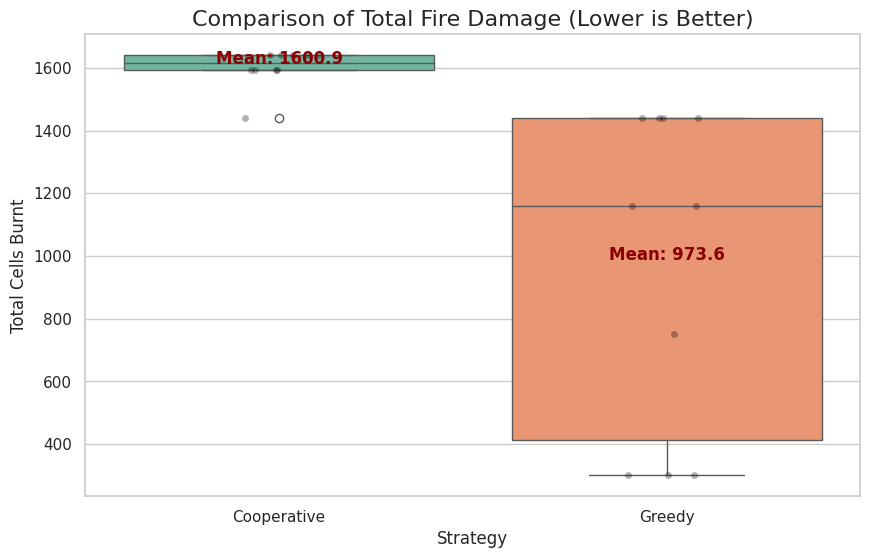

Analysis: The Box Plot shows the distribution of damage. If 'Cooperative' is lower, your hypothesis is correct.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
# --- CELL 7: VISUALIZATION - FINAL DAMAGE (SAVED TO DRIVE) ---
if 'full_stats' in locals():
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    # Create Box Plot
    ax = sns.boxplot(data=full_stats, x="Agent", y="Final Burnt Cells", palette="Set2")
    sns.stripplot(data=full_stats, x="Agent", y="Final Burnt Cells", color="black", alpha=0.3)

    plt.title("Comparison of Total Fire Damage (Lower is Better)", fontsize=16)
    plt.ylabel("Total Cells Burnt", fontsize=12)
    plt.xlabel("Strategy", fontsize=12)

    # Add mean labels
    means = full_stats.groupby("Agent")["Final Burnt Cells"].mean()
    for i, agent in enumerate(["Cooperative", "Greedy"]):
        if agent in means:
            plt.text(i, means[agent], f"Mean: {means[agent]:.1f}",
                     ha='center', va='bottom', fontweight='bold', color='darkred')

    # --- SAVE TO DRIVE ---
    plot_path = f"{drive_save_path}/plot_damage_comparison.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to: {plot_path}")

    plt.show()

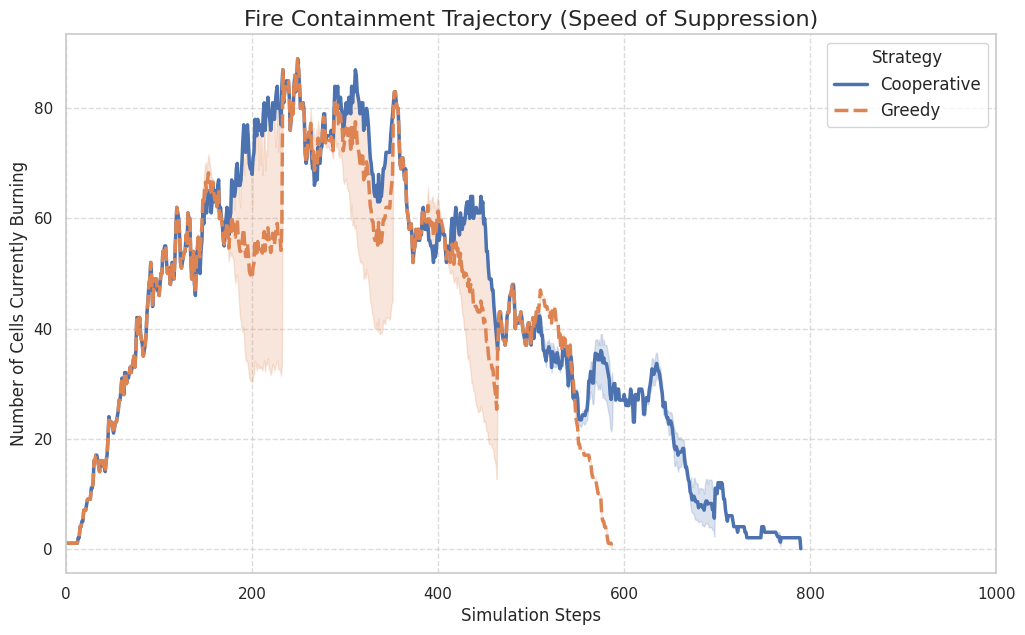

Analysis: This curve shows WHO IS FASTER. A steeper downward slope means the team reacts quicker.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [8]:
# --- CELL 8: VISUALIZATION - FIRE SPEED (SAVED TO DRIVE) ---
if 'full_curves' in locals():
    plt.figure(figsize=(12, 7))

    # Create Line Plot
    sns.lineplot(data=full_curves, x="Step", y="Active Fire", hue="Agent", style="Agent", linewidth=2.5)

    plt.title("Fire Containment Trajectory (Speed of Suppression)", fontsize=16)
    plt.ylabel("Active Fire Size (Cells)", fontsize=12)
    plt.xlabel("Simulation Steps", fontsize=12)
    plt.legend(title="Strategy", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(0, 1000)

    # --- SAVE TO DRIVE ---
    plot_path = f"{drive_save_path}/plot_containment_speed.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to: {plot_path}")

    plt.show()

✅ Plot saved to: /content/drive/MyDrive/FirecastRL_Models/plot_scatter_efficiency.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


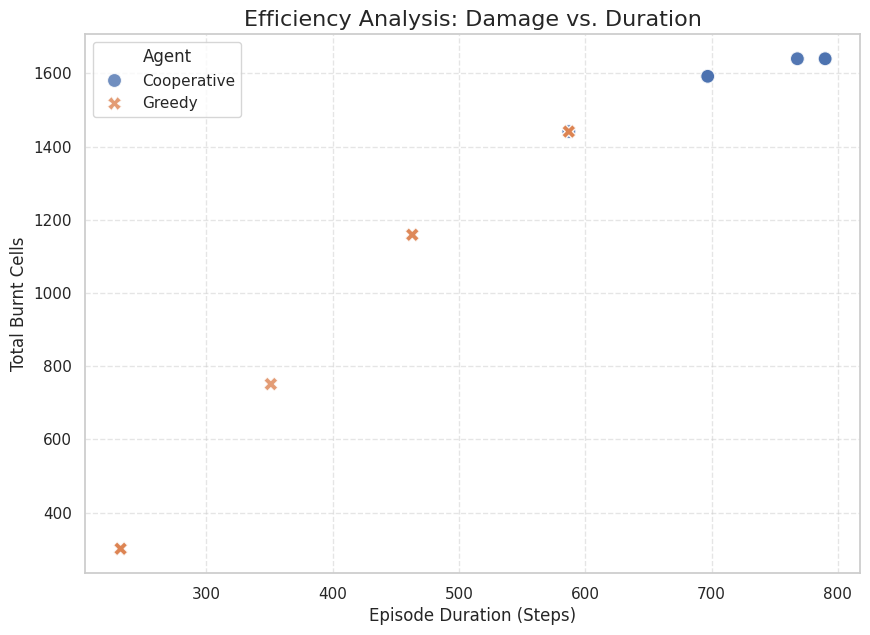

In [10]:
# --- CELL 10: VISUALIZATION - SCATTER PLOT (SAVED TO DRIVE) ---
if 'full_stats' in locals() and 'full_curves' in locals():
    plt.figure(figsize=(10, 7))

    # 1. Calculate Duration for each episode
    # (We infer this from the max step count in the curves data)
    durations = full_curves.groupby(['Agent', 'Episode'])['Step'].max().reset_index()
    durations.rename(columns={'Step': 'Duration'}, inplace=True)

    # 2. Merge with the stats
    merged_data = pd.merge(full_stats, durations, on=['Agent', 'Episode'])

    # 3. Create Scatter Plot
    sns.scatterplot(
        data=merged_data,
        x="Duration",
        y="Final Burnt Cells",
        hue="Agent",
        style="Agent",
        s=100, # Dot size
        alpha=0.8,
        palette="deep"
    )

    plt.title("Efficiency Analysis: Damage vs. Duration", fontsize=16)
    plt.xlabel("Episode Duration (Steps)", fontsize=12)
    plt.ylabel("Total Burnt Cells", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)

    # --- SAVE ---
    plot_path = f"{drive_save_path}/plot_scatter_efficiency.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to: {plot_path}")

    plt.show()

✅ Plot saved to: /content/drive/MyDrive/FirecastRL_Models/plot_risk_density.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


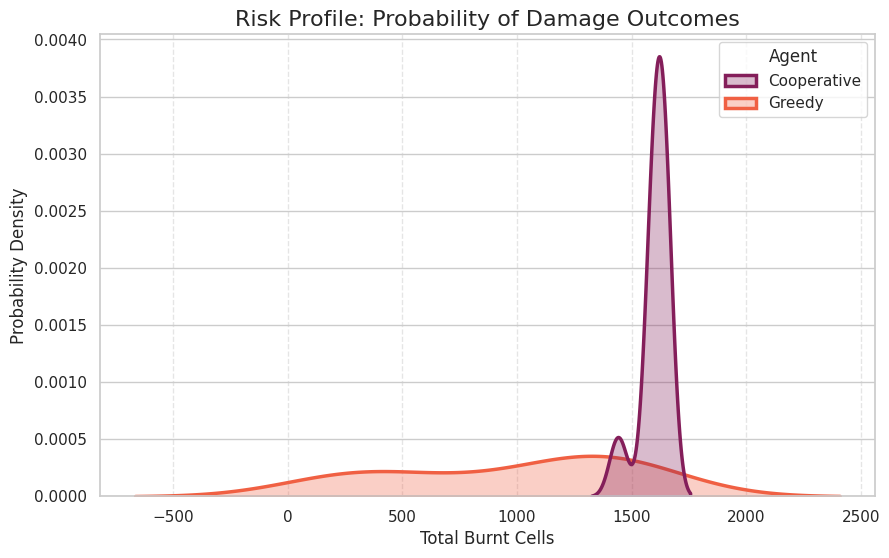

In [11]:
# --- CELL 11: VISUALIZATION - RISK DENSITY (SAVED TO DRIVE) ---
if 'full_stats' in locals():
    plt.figure(figsize=(10, 6))

    # Kernel Density Estimate (KDE) Plot
    # "fill=True" makes the area under the curve solid
    sns.kdeplot(
        data=full_stats,
        x="Final Burnt Cells",
        hue="Agent",
        fill=True,
        alpha=0.3,
        linewidth=2.5,
        palette="rocket"
    )

    plt.title("Risk Profile: Probability of Damage Outcomes", fontsize=16)
    plt.xlabel("Total Burnt Cells", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # --- SAVE ---
    plot_path = f"{drive_save_path}/plot_risk_density.png"
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved to: {plot_path}")

    plt.show()

In [12]:
# --- CELL 12: EXTENDED FINAL REPORT SUMMARY ---
if 'full_stats' in locals() and 'full_curves' in locals():
    print("="*60)
    print("🔥 FIRECAST RL - FINAL PROJECT REPORT 🔥")
    print("="*60)

    # 1. Calculate Duration (Speed) for each episode
    # (We extract this from the curves data like we did for the scatter plot)
    durations = full_curves.groupby(['Agent', 'Episode'])['Step'].max().reset_index()
    durations.rename(columns={'Step': 'Duration'}, inplace=True)

    # Merge duration into the main stats dataframe
    final_data = pd.merge(full_stats, durations, on=['Agent', 'Episode'])

    # 2. Group by Agent and calculate comprehensive stats
    summary = final_data.groupby("Agent").agg({
        "Final Burnt Cells": ["mean", "std", "min", "max"],
        "Total Quenched": ["mean"],
        "Duration": ["mean", "std"]  # NEW: Track speed!
    }).round(2)

    # Rename columns for clarity
    summary.columns = [
        "Avg Burnt", "Risk (Std)", "Best Case", "Worst Case",
        "Avg Quenched",
        "Avg Steps (Speed)", "Speed Var"
    ]

    print("\n📊 STATISTICAL PERFORMANCE:")
    print(summary)

    # 3. Calculate Improvement Percentages
    means = final_data.groupby("Agent")["Final Burnt Cells"].mean()
    speeds = final_data.groupby("Agent")["Duration"].mean()

    if "Cooperative" in means and "Greedy" in means:
        diff_burn = means["Greedy"] - means["Cooperative"]
        pct_burn = (diff_burn / means["Greedy"]) * 100

        diff_speed = speeds["Greedy"] - speeds["Cooperative"]

        print("\n🏆 FINAL CONCLUSION:")
        print(f"1. DAMAGE CONTROL:")
        if diff_burn > 0:
            print(f"   - The COOPERATIVE squad saved {diff_burn:.2f} more trees on average.")
            print(f"   - This is a {pct_burn:.1f}% improvement in forest protection.")
        else:
            print(f"   - The Greedy squad actually saved {abs(diff_burn):.2f} more trees.")

        print(f"\n2. EFFICIENCY:")
        if diff_speed > 0:
             print(f"   - The COOPERATIVE squad was faster by {diff_speed:.1f} steps.")
        else:
             print(f"   - The Greedy squad was faster by {abs(diff_speed):.1f} steps.")

    print("\n✅ Recommendation: Copy these numbers into your PDF report table.")
    print("="*60)

🔥 FIRECAST RL - FINAL PROJECT REPORT 🔥

📊 STATISTICAL PERFORMANCE:
             Avg Burnt  Risk (Std)  Best Case  Worst Case  Avg Quenched  \
Agent                                                                     
Cooperative     1600.9       61.04       1441        1640           0.0   
Greedy           973.6      510.92        301        1441           0.0   

             Avg Steps (Speed)  Speed Var  
Agent                                      
Cooperative              728.1      65.37  
Greedy                   432.1     157.97  

🏆 FINAL CONCLUSION:
1. DAMAGE CONTROL:
   - The Greedy squad actually saved 627.30 more trees.

2. EFFICIENCY:
   - The Greedy squad was faster by 296.0 steps.

✅ Recommendation: Copy these numbers into your PDF report table.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
